In [1]:
## import some modules between which also our hammer_fit

import numpy as np
import pyhf
import matplotlib.pyplot as plt
import json
from redist import modifier
from redist import hammer_fit

In [2]:
# you can define your fitter in a json file and it will contain all the informations about:
#   - WCs to pass to Hammer
#   - FF parametrization in use
#   - the location of the file containing the hammer histograms

reader = hammer_fit.Reader("./B02DstTauNu_config.json")

# createFitter produces a fitter object able handle the hammer histograms and produce the templates
fitter = reader.createFitter()

# store in your fitter your data (this is not necessary as you can always fit external data)
# the parameters are defined in the json file and here we produce a SM like toy we aim to fit
params_toy = {"SM" : 1., "Re_S_qLlL" : 0., "Im_S_qLlL" : 0., "Re_S_qRlL" : 0., "Im_S_qRlL" : 0.,  "Re_V_qLlL" : 0., "Im_V_qLlL" : 0. , "Re_V_qRlL" : 0., "Im_V_qRlL" : 0., "Re_T_qLlL" : 0., "Im_T_qLlL" : 0., "delta_RhoSq" : 0., "delta_cSt" : 0., "delta_chi21" : 0., "delta_chi2p" : 0., "delta_chi3p" : 0., "delta_eta1" : 0., "delta_etap" : 0., "delta_phi1p" : 0., "delta_beta21" : 0., "delta_beta3p" : 0.,"lumi" : 1.}
toy_data = fitter._template_list[0].generate_toy(**params_toy) + fitter._template_list[1].generate_toy(**params_toy)

fitter.upload_data(toy_data)

/home/mcolonna/.conda/envs/env_2024_11_25/lib/python3.10/site-packages/redist/hammer_fit.py:706: RuntimeWarning: invalid value encountered in divide
  ratio = contributions[0][i] / total_contribution
/home/mcolonna/.conda/envs/env_2024_11_25/lib/python3.10/site-packages/redist/hammer_fit.py:707: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt(contributions[0][i]) / total_contribution


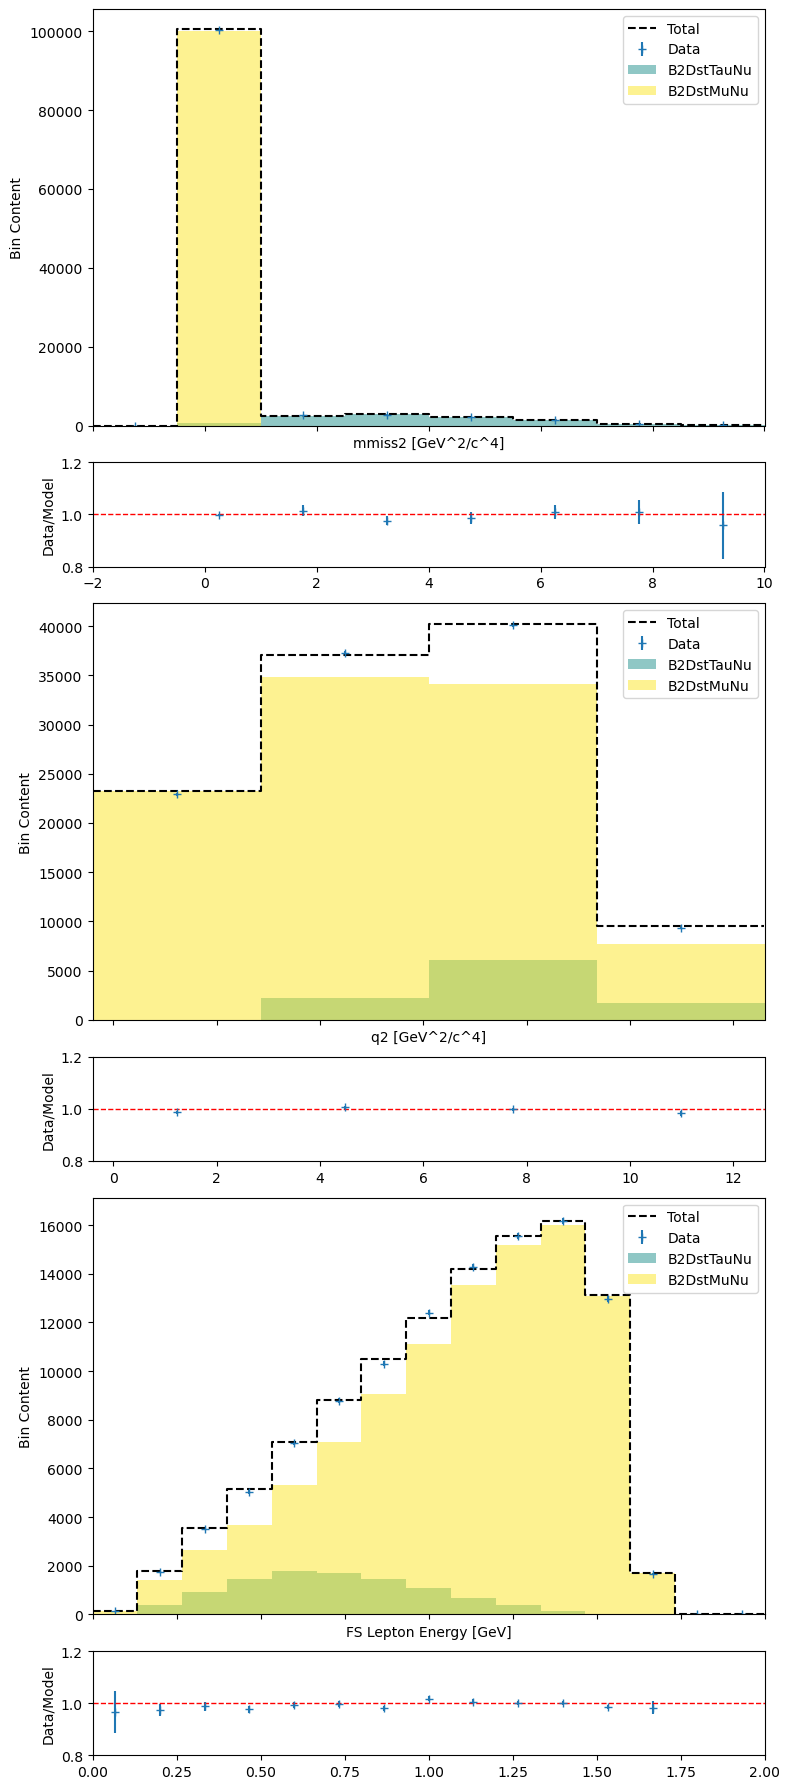

In [3]:
# let's look to what is now inside the fitter object
# - a toy dataset (Data)
# - a template for B2DstTauNu varying with the WCs and the FFs
# - a template for B2DstMuNu varying with the FFs (NP in tau-mode only)
fitter.plot(**params_toy)

In [4]:
# definition of the alternative model (the nul model is stored in the fitter object)
SM_dist = fitter.nul_pdf()

def NP_dist(**kwargs):
    params_NP = {"SM" : kwargs["SM"], "Re_S_qLlL" : kwargs["Re_S_qLlL"], "Im_S_qLlL" : kwargs["Im_S_qLlL"], "Re_S_qRlL" : kwargs["Re_S_qRlL"], "Im_S_qRlL" : kwargs["Im_S_qRlL"],  "Re_V_qLlL" : kwargs["Re_V_qLlL"], "Im_V_qLlL" : kwargs["Im_V_qLlL"], "Re_V_qRlL" : kwargs["Re_V_qRlL"], "Im_V_qRlL" : kwargs["Im_V_qRlL"], "Re_T_qLlL" : kwargs["Re_T_qLlL"], "Im_T_qLlL" : kwargs["Im_T_qLlL"],"delta_RhoSq" : kwargs["FFs[8]"], "delta_cSt" : kwargs["FFs[0]"], "delta_chi21" : kwargs["FFs[6]"], "delta_chi2p" : kwargs["FFs[2]"], "delta_chi3p" : kwargs["FFs[9]"], "delta_eta1" : kwargs["FFs[7]"], "delta_etap" : kwargs["FFs[3]"], "delta_phi1p" : kwargs["FFs[1]"], "delta_beta21" : kwargs["FFs[5]"], "delta_beta3p" : kwargs["FFs[4]"],"lumi" : 1.}
    res = np.zeros(fitter._template_list[0]._nobs)
    for temp in fitter._template_list:
        res += temp.generate_template(**params_NP)
    return res

In [5]:
# Definition of the custom modifiers as the Wilson coefficients and the eigenvectors of the FFs

new_params = {
                'SM'   :{'inits': (1.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'Re_S_qLlL'   :{'inits': (0.,), 'bounds': ((-1.,1.),), 'paramset_type': 'unconstrained'},
                'Im_S_qLlL'   :{'inits': (0.,), 'bounds': ((-2.,2.),), 'paramset_type': 'unconstrained'},
                'Re_S_qRlL'   :{'inits': (0.,), 'bounds': ((-1.,1.),), 'paramset_type': 'unconstrained'},
                'Im_S_qRlL'   :{'inits': (0.,), 'bounds': ((-2.,2.),), 'paramset_type': 'unconstrained'},
                'Re_V_qLlL'   :{'inits': (0.,), 'bounds': ((-0.3,0.3),), 'paramset_type': 'unconstrained'},
                'Im_V_qLlL'   :{'inits': (0.,), 'bounds': ((-1.,1.),), 'paramset_type': 'unconstrained'},
                'Re_V_qRlL'   :{'inits': (0.,), 'bounds': ((-0.3,0.3),), 'paramset_type': 'unconstrained'},
                'Im_V_qRlL'   :{'inits': (0.,), 'bounds': ((-1.,1.),), 'paramset_type': 'unconstrained'},
                'Re_T_qLlL'   :{'inits': (0.,), 'bounds': ((-0.1,0.1),), 'paramset_type': 'unconstrained'},
                'Im_T_qLlL'   :{'inits': (0.,), 'bounds': ((-0.2,0.2),), 'paramset_type': 'unconstrained'},
                'FFs'         :{'inits': (0.,0.,0.,0.,0.,0.,0.,0.,0.,0.), 'bounds': (),
                                'cov': [[0.05*0.05,0.,0.,0.,0.,0.,0.,0.,0.,0.],
                                        [0.,0.05*0.05,0.,0.,0.,0.,0.,0.,0.,0.],
                                        [0.,0.,0.05*0.05,0.,0.,0.,0.,0.,0.,0.],
                                        [0.,0.,0.,0.05*0.05,0.,0.,0.,0.,0.,0.],
                                        [0.,0.,0.,0.,0.05*0.05,0.,0.,0.,0.,0.],
                                        [0.,0.,0.,0.,0.,0.05*0.05,0.,0.,0.,0.],
                                        [0.,0.,0.,0.,0.,0.,0.05*0.05,0.,0.,0.],
                                        [0.,0.,0.,0.,0.,0.,0.,0.05*0.05,0.,0.],
                                        [0.,0.,0.,0.,0.,0.,0.,0.,0.05*0.05,0.],
                                        [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.05*0.05],],
                                'paramset_type': 'constrained_by_normal'}
                }         


cmod = hammer_fit.Hammer_Modifier(new_params, NP_dist, SM_dist)

In [6]:
# create and save the pyhf model

data_init = SM_dist()

spec = {
  "channels": [
    {
      "name": "doublechannel",
      "samples": [
        {
          "name": "signal",
          "data": data_init.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
      ]
    } 
  ]
}


model = pyhf.Model(spec)
custom_mod = {
                "name": "custom_modifier",
                "type": "custom",
                "data":
                    {
                        "expr": "custom_weight_fn",
                    }
              }

model = modifier.add_to_model(model, ['doublechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
hammer_fit.save_hammer('B02DstTauNu_model.json', model.spec, [cmod], fitter._data.tolist())